In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
S_thold = -100
# T_av = 1108e3
dmByDt = 78.75
A_side_proj = 10*5
A_front_proj = np.pi*2.5*2.5

THETA = 6.4 # in degrees
MASS = 6e3 # in kg
DT = 0.001 # in seconds

def thrust(alpha,theta=np.deg2rad(THETA),T_hb = (2*267*np.cos(THETA) + 2*267 + 2*20)*1e3
,T_vb = (2*267*np.sin(THETA)),mass=MASS):
    """ 
    calculates thrust in inertial (parent) direction
    inputs:
    - alpha in rad
    - theta in rad
    - T in N (absolute value of net thrust)

    output:
    - 2D vector

    Notes: 
    Mg force is added in this just cz it was acting on CG itself, and I didnt't wanna make many changes
    """

    # have added this because we were not able to change the direction of all motor, it was feasible only for 2
    # so have modified the net thrust based on theta 


    
    T = np.sqrt(T_hb**2+T_vb**2)


    # the return statement of this function includes mg term also  
    # hence it outputs thrust + mg in vector for in parent's frame  
    return np.array([T*np.cos(-alpha+theta),-T*np.sin(-alpha+theta)-mass*9.8])



def drag(alpha,beta,D = 1e6):
    """
    calculates drag in inertial (parent) direction
    inputs:
    - alpha in rad
    - beta in rad
    - D in N (absolute value of net thrust)

    output: 
    - 2D vector
    """
    return np.array([-D*np.cos(beta-alpha),D*np.sin(beta-alpha)])

def R_i2b(alpha,vec):
    """ 
    returns rotated vector in the body frame (x,y) from the interial {parent (X,Y)}
    alpha in rad
    """
    rotMat = np.array( [ [ np.cos(alpha), np.sin(alpha) ], [ -np.sin(alpha), np.cos(alpha)] ] )   
    return np.matmul(rotMat,vec)

def moment(alpha, drag, l = 0.5):
    """ 
    calculates positive value standard right hand rule i.e. outside plane moment is positive
    l is distance between cg and cp
    distance between cg and ct is assumed 0 {ct is the point at which thrust acts}
    """
    dragRot = -R_i2b(alpha,drag)
    return dragRot[1]*l

def moi(m=6000,r=2.5,l=10):
    """
    moment of intertia, will be used in future for variable mass and exact CG location
    """
    return m*(0.25*r**2 + (1/12)*l**2)+m*(1.5)**2


def betaFromV(alpha, v):
    """
    input:
    - alpha in radians
    - velocity vector in inertial frame
    output:
    - in radians
    """
    vRot = R_i2b(alpha,v) # transform velcity vector from parent to pod frame
    return np.arctan(-vRot[1]/vRot[0])

def updateV(vo, T, D, dt = DT, m = MASS):
    """
    newton's law
    """
    # return vo + ((T+D)/m+np.array([0,-9.8]))*dt # for absolute displacement in Y (but first have to rotate everything in real inertial frame)
    return vo + ((T+D)/m)*dt

def updateAlphadot(alphaDot, moment, moi, dt = DT):
    """
    we know that doube derivative of alpha wrt time is net_Torque/Moment of inertia
    input:
    - rad/sec
    - N-m
    - kg-m^2
    """
    return alphaDot + (moment/moi)*dt

def updateAlpha(alphao, alphaDot, dt = DT):
    """ 
    took modulus for plots
    """
    # return (alphao + alphaDot*dt)%(2*np.pi)
    return (alphao + alphaDot*dt)

def getAngle(vec):
    return np.arctan(vec[1]/vec[0])


In [2]:
def rho(h):
    return pow(1.225*(1-22.558e-6*h),4.2559) #h in meter

In [3]:
def loopAll( theta = 6.4,dragNew = 1e6,loopTime = 100):
    MASS = 6e3
    #declaring empty arrays
    t = np.arange(0,loopTime+DT,DT) 
    alph = np.zeros(len(t))
    bet = np.zeros(len(t))
    T = np.zeros((len(t),2))
    D = np.zeros((len(t),2))
    V = np.zeros((len(t),2))
    alphDot = np.zeros(len(t))
    tau = np.zeros(len(t)) 
    sy = 0
    # initializing t = 0 values
    T[0] = thrust(alph[0],np.deg2rad(theta))
    D[0] = drag(alph[0],bet[0],dragNew)
    V[0] = np.array([600,0])
    I = moi()
    updatedMASS = MASS
    for i in range(1,len(t)):
        if(i<int(2.708/DT)):
            updatedMASS = MASS - 6*dmByDt*DT
            V[i] = updateV(V[i-1],T[i-1],D[i-1],DT,updatedMASS)
            sy = sy + V[i][1]*DT
            bet[i] = betaFromV(alph[i-1],V[i])
            tau[i] = moment(alph[i-1],D[i-1])
            alphDot[i] = updateAlphadot(alphDot[i-1],tau[i],moi(updatedMASS))
            alph[i] = updateAlpha(alph[i-1],alphDot[i-1])
            T[i] = thrust(alph[i],np.deg2rad(theta))
            D[i] = drag(alph[i],bet[i],dragNew)
        else:
            V[i] = updateV(V[i-1],T[i-1],D[i-1],DT,updatedMASS)
            sy = sy + V[i][1]*DT
            bet[i] = betaFromV(alph[i-1],V[i])
            tau[i] = moment(alph[i-1],D[i-1])
            alphDot[i] = updateAlphadot(alphDot[i-1],tau[i],moi(updatedMASS))
            alph[i] = updateAlpha(alph[i-1],alphDot[i-1])
            T[i] = thrust(alph[i],np.deg2rad(theta),0,0,updatedMASS)
            D[i] = drag(alph[i],bet[i],0.8*0.5*rho(11000-sy)*(np.linalg.norm(V[i])**2)*(( A_side_proj * np.sin(bet[i]) + A_front_proj * np.cos(bet[i]) )))
    return alph,bet,V,

In [4]:
alph,bet,V = loopAll()

In [5]:
S = np.array([np.cumsum(V[:,0]),np.cumsum(V[:,1])])*DT

In [6]:
S_parent = 600*np.cumsum(np.ones(len(S[0]))*DT)

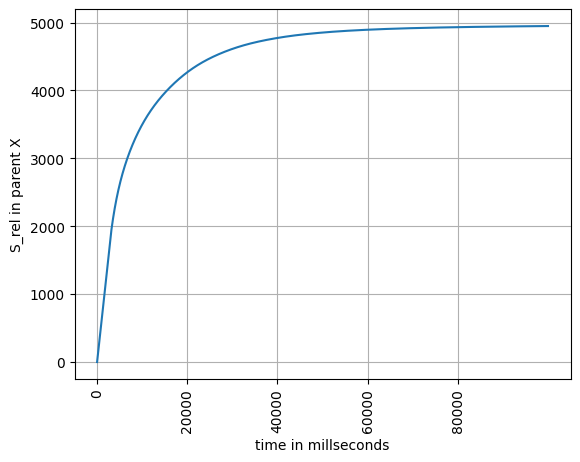

In [13]:
plt.plot(S[0])
plt.ylabel('S_rel in parent X')
plt.xlabel('time in millseconds')
plt.xticks(np.arange(0,100000,20000),rotation = 'vertical')
plt.grid()

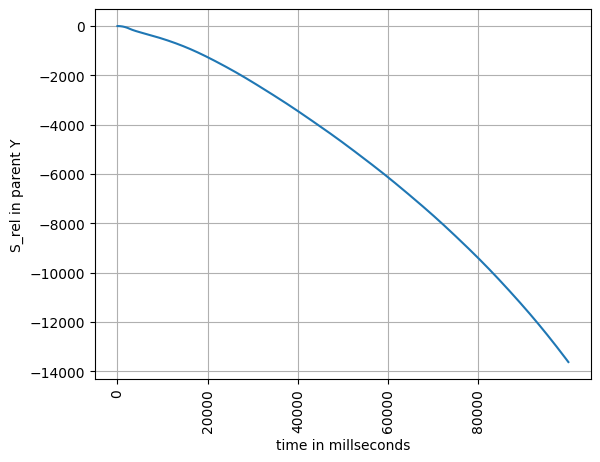

In [12]:
plt.plot(S[1])
plt.ylabel('S_rel in parent Y')
plt.xlabel('time in millseconds')
plt.xticks(np.arange(0,100000,20000),rotation = 'vertical')
plt.grid()

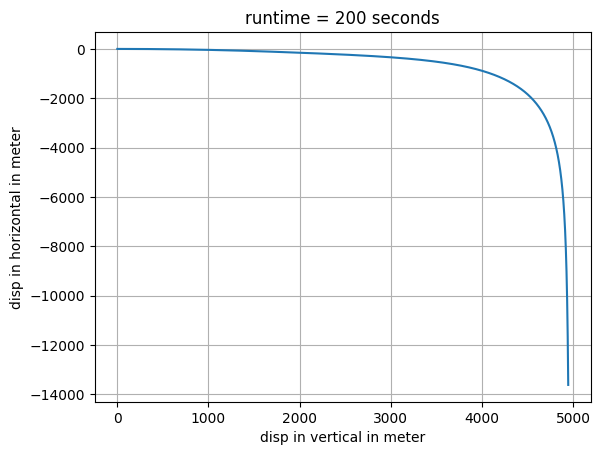

In [10]:
plt.plot(S[0],S[1])
plt.ylabel('disp in horizontal in meter')
plt.xlabel('disp in vertical in meter')
plt.title('runtime = 200 seconds')
# plt.xticks(np.arange(0,4000,500),rotation = 'vertical')
plt.grid()